# Basic Text Classification w/ Keras

https://www.tensorflow.org/tutorials/keras/text_classification

In [1]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf

from pathlib import Path
from tensorflow.keras import layers, losses, preprocessing
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

# Binary Classification (Dataset: IMDB Reviews)

## Dataset Fetch

In [9]:
dataset_url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

In [10]:
datasets_dir = Path(os.path.abspath('')).parent.joinpath('datasets')
datasets_dir.mkdir(parents=True, exist_ok=True)

In [11]:
dataset = tf.keras.utils.get_file(fname="aclImdb_v1.tar.gz", 
                                  origin=dataset_url,
                                  extract=True, 
                                  cache_dir=datasets_dir,
                                  cache_subdir='')

84131840/84125825 [==============================] - 27s 0us/step


In [12]:
imdb_dataset_dir = datasets_dir.joinpath('aclimdb')

In [13]:
imdb_train_dataset = imdb_dataset_dir.joinpath('train')
imdb_test_dataset = imdb_dataset_dir.joinpath('test')

In [14]:
os.listdir(imdb_train_dataset)

['urls_unsup.txt',
 'neg',
 'urls_pos.txt',
 'unsup',
 'urls_neg.txt',
 'pos',
 'unsupBow.feat',
 'labeledBow.feat']

In [15]:
"""Drops the 'unsup' dataset since we're doing a binary classification (pos/neg)"""
imdb_train_dataset_unsup = imdb_train_dataset.joinpath('unsup')
shutil.rmtree(imdb_train_dataset_unsup, ignore_errors=True)

## Dataset Load

In [16]:
"""
Loads the Dataset in Batches/Lists of 32 entries each,
meaning that each iteration over the dataset will return 32 reviews
"""
batch_size = 32
seed = 42

### Loading Training Dataset

In [17]:
raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    imdb_train_dataset,
    batch_size=batch_size,
    seed=seed,
    validation_split=0.2,
    subset='training'
)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


### Analysis of the Training Dataset

In [54]:
"""Available Classes"""
raw_train_ds.class_names

['neg', 'pos']

In [19]:
for text_batch, label_batch in raw_train_ds.take(1):
    for i in range(3):
        tokenized_label = label_batch.numpy()[i]
        corpus=text_batch.numpy()[i]
        class_name = raw_train_ds.class_names[tokenized_label]
        print(f"Label: {tokenized_label} ({class_name})")
        print(f"Review: {corpus}")
        print()

Label: 0 (neg)
Review: b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'

Label: 0 (neg)
Review: b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life 

### Loading Validation Dataset

In [53]:
raw_validation_ds = tf.keras.preprocessing.text_dataset_from_directory(
    imdb_train_dataset,
    batch_size=batch_size,
    seed=seed,
    validation_split=0.2,
    subset='validation'
)

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


### Loading Test Dataset

In [21]:
raw_test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    imdb_test_dataset,
    batch_size=batch_size
)

Found 25000 files belonging to 2 classes.


## Dataset Preprocessing

### Standarization Function

In [22]:
def standardize_fn(input_data):
    lowercase_corpus = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(input=lowercase_corpus, 
                                             pattern='<br />', 
                                             rewrite='')

    return tf.strings.regex_replace(input=stripped_html, 
                                    pattern='[%s]' % re.escape(string.punctuation), 
                                    rewrite='')

### Tokenization & Vectorization

In [23]:
"""Define the size of the vocabulary (the max number of words to be tokenized)"""
max_features = 100000
sequence_length = 250

vectorize_layer = TextVectorization(
    standardize=standardize_fn,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length
)

def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

### Testing & Visualization

In [24]:
train_text = raw_train_ds.map(lambda text, class_label: text)

In [25]:
vectorize_layer.adapt(train_text)

In [26]:
# retrieve a batch (of 32 reviews and labels) from the dataset
text_batch, label_batch = next(iter(raw_train_ds))
review, label = text_batch[0], label_batch[0]

In [27]:
print("Review: ", review)

Review:  tf.Tensor(b'Silent Night, Deadly Night 5 is the very last of the series, and like part 4, it\'s unrelated to the first three except by title and the fact that it\'s a Christmas-themed horror flick.<br /><br />Except to the oblivious, there\'s some obvious things going on here...Mickey Rooney plays a toymaker named Joe Petto and his creepy son\'s name is Pino. Ring a bell, anyone? Now, a little boy named Derek heard a knock at the door one evening, and opened it to find a present on the doorstep for him. Even though it said "don\'t open till Christmas", he begins to open it anyway but is stopped by his dad, who scolds him and sends him to bed, and opens the gift himself. Inside is a little red ball that sprouts Santa arms and a head, and proceeds to kill dad. Oops, maybe he should have left well-enough alone. Of course Derek is then traumatized by the incident since he watched it from the stairs, but he doesn\'t grow up to be some killer Santa, he just stops talking.<br /><br /

In [28]:
print("Standarized Review: ", standardize_fn(review))

Standarized Review:  tf.Tensor(b'silent night deadly night 5 is the very last of the series and like part 4 its unrelated to the first three except by title and the fact that its a christmasthemed horror flickexcept to the oblivious theres some obvious things going on heremickey rooney plays a toymaker named joe petto and his creepy sons name is pino ring a bell anyone now a little boy named derek heard a knock at the door one evening and opened it to find a present on the doorstep for him even though it said dont open till christmas he begins to open it anyway but is stopped by his dad who scolds him and sends him to bed and opens the gift himself inside is a little red ball that sprouts santa arms and a head and proceeds to kill dad oops maybe he should have left wellenough alone of course derek is then traumatized by the incident since he watched it from the stairs but he doesnt grow up to be some killer santa he just stops talkingtheres a mysterious stranger lurking around who seem

In [29]:
print("Label: ", raw_train_ds.class_names[label])

Label:  neg


In [30]:
print("Vectorized review: ", vectorize_text(review, label))

Vectorized review:  (<tf.Tensor: shape=(1, 250), dtype=int64, numpy=
array([[ 1270,   312,  2355,   312,   682,     7,     2,    51,   227,
            5,     2,   203,     3,    37,   170,   725,    29,  5496,
            6,     2,    86,   295,   541,    32,   427,     3,     2,
          185,    12,    29,     4,     1,   191,     1,     6,     2,
         8333,   221,    46,   573,   176,   167,    20, 94681,  5434,
          284,     4, 25205,   752,   965, 25879,     3,    24,   931,
         2275,   396,     7, 14156,  1655,     4,  3734,   252,   157,
            4,   110,   437,   752,  3561,   538,     4,  3648,    30,
            2,  1347,    28,  2121,     3,  2877,     9,     6,   160,
            4,   998,    20,     2, 16825,    15,    88,    54,   149,
            9,   290,    89,   960,  2273,   983,    27,   766,     6,
          960,     9,   687,    18,     7,  2138,    32,    24,  1265,
           36, 33282,    88,     3,  3249,    88,     6,  1411,     3,
        

In [31]:
print("{token} ==> {word}".format(token=11, word=vectorize_layer.get_vocabulary()[11]))
print("{token} ==> {word}".format(token=57, word=vectorize_layer.get_vocabulary()[57]))
print("{token} ==> {word}".format(token=1270, word=vectorize_layer.get_vocabulary()[1270]))

print("Vocabulary Size: {size}".format(size=len(vectorize_layer.get_vocabulary())))

11 ==> i
57 ==> would
1270 ==> silent
Vocabulary Size: 100000


### Applying Vectorization on Training/Validation/Test Datasets

In [32]:
train_ds = raw_train_ds.map(vectorize_text)
validation_ds = raw_validation_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

### Caching Datasets to RAM

In [33]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds.cache().prefetch(buffer_size=AUTOTUNE)
validation_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds.cache().prefetch(buffer_size=AUTOTUNE)

<PrefetchDataset shapes: ((None, 250), (None,)), types: (tf.int64, tf.int32)>

## Model Training

### Model Parametrization

In [34]:
embedding_dim = 16

In [35]:
model = tf.keras.Sequential([
    layers.Embedding(max_features+1, embedding_dim),
    layers.Dropout(0.2),
    layers.GlobalAveragePooling1D(),
    layers.Dropout(0.2),
    layers.Dense(1)
])

In [36]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          1600016   
_________________________________________________________________
dropout (Dropout)            (None, None, 16)          0         
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 1,600,033
Trainable params: 1,600,033
Non-trainable params: 0
_________________________________________________________________


In [37]:
model.compile(
    loss=losses.BinaryCrossentropy(from_logits=True),
    optimizer='adam',
    metrics=tf.metrics.BinaryAccuracy(threshold=0.0)
)

### Model Training

In [38]:
epochs = 10

In [39]:
history = model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=epochs
)

Epoch 1/10
625/625 [==============================] - 19s 29ms/step - loss: 0.6825 - binary_accuracy: 0.6173 - val_loss: 0.6127 - val_binary_accuracy: 0.7840
Epoch 2/10
625/625 [==============================] - 18s 28ms/step - loss: 0.5745 - binary_accuracy: 0.7974 - val_loss: 0.4950 - val_binary_accuracy: 0.8250
Epoch 3/10
625/625 [==============================] - 11s 17ms/step - loss: 0.4560 - binary_accuracy: 0.8432 - val_loss: 0.4171 - val_binary_accuracy: 0.8522
Epoch 4/10
625/625 [==============================] - 8s 13ms/step - loss: 0.3756 - binary_accuracy: 0.8722 - val_loss: 0.3710 - val_binary_accuracy: 0.8640
Epoch 5/10
625/625 [==============================] - 8s 12ms/step - loss: 0.3218 - binary_accuracy: 0.8923 - val_loss: 0.3403 - val_binary_accuracy: 0.8706
Epoch 6/10
625/625 [==============================] - 9s 14ms/step - loss: 0.2821 - binary_accuracy: 0.9079 - val_loss: 0.3204 - val_binary_accuracy: 0.8754
Epoch 7/10
625/625 [==============================] - 1

### Model Evaluation

In [40]:
loss, accuracy = model.evaluate(test_ds)

782/782 [==============================] - 13s 16ms/step - loss: 0.3176 - binary_accuracy: 0.8696


In [41]:
print(f"Loss: {loss}")
print(f"Accuracy: {accuracy}")

Loss: 0.3176394999027252
Accuracy: 0.8695999979972839


### Model Explainability

In [42]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

In [43]:
bin_acc = history_dict['binary_accuracy']
validation_acc = history_dict['val_binary_accuracy']

In [44]:
loss = history_dict['loss']
validation_loss = history_dict['val_loss']

In [45]:
epochs = range(1, len(bin_acc) + 1)

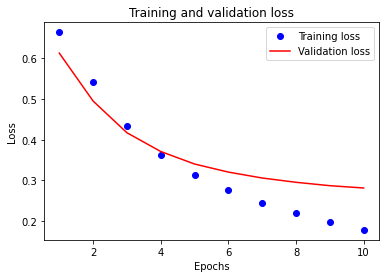

In [46]:
# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, validation_loss, 'red', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

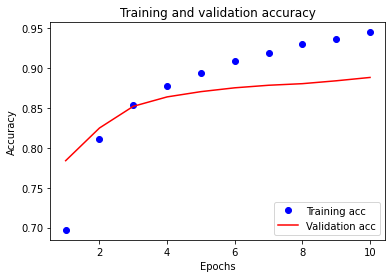

In [47]:
plt.plot(epochs, bin_acc, 'bo', label='Training acc')
plt.plot(epochs, validation_acc, 'red', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

### Model Export

In [48]:
export_model = tf.keras.Sequential([
    vectorize_layer,
    model,
    layers.Activation('sigmoid')
])

In [49]:
export_model.compile(loss=losses.BinaryCrossentropy(from_logits=False),
                     optimizer='adam',
                     metrics=['accuracy'])

In [50]:
loss, accuracy = export_model.evaluate(raw_test_ds)

782/782 [==============================] - 11s 14ms/step - loss: 0.3130 - accuracy: 0.8718


In [51]:
print(f"Loss: {loss}")
print(f"Accuracy: {accuracy}")

Loss: 0.3176393210887909
Accuracy: 0.8695999979972839


## Model Inference

In [52]:
examples = [
  "The movie was great!",
  "The movie was okay.",
  "The movie was terrible..."
]

export_model.predict(examples)

array([[0.6231635 ],
       [0.43973327],
       [0.35921806]], dtype=float32)